In [1]:
# ========================================
# 1. Upload file (nëse je në Colab)
# ========================================
from google.colab import files
uploaded = files.upload()


In [2]:
# ========================================
# 2. Import libraritë
# ========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# ========================================
# 3. Lexo CSV-n
# ========================================
df = pd.read_csv("/time_series_cleaned_final_fund.csv")
df.head()


,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,rating,genre,rating_category,main_genre
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High,Adventure
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High,Crime
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High,Documentary
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,Action
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High,Adventure


In [5]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [6]:
# ========================================
# 4. Përgatitja e të dhënave
# ========================================
# X = 100 ditët e para të të ardhurave
X = df[[str(i) for i in range(100)]].fillna(0).values
# Normalizim per çdo film veçmas
X = (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True) + 1e-8)
# Riformatim për RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

# y = main_genre e koduar
le = LabelEncoder()
y = le.fit_transform(df["main_genre"])
y_cat = to_categorical(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (907, 100, 1)
y shape: (907, 12)


In [7]:
# ========================================
# 5. Ndërtimi i modelit RNN
# ========================================
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(100, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Trajnimi
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.2576 - loss: 2.4321 - val_accuracy: 0.2473 - val_loss: 2.1388
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2385 - loss: 2.1621 - val_accuracy: 0.2473 - val_loss: 2.0799
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2328 - loss: 2.0462 - val_accuracy: 0.2473 - val_loss: 2.0842
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2641 - loss: 2.0463 - val_accuracy: 0.2473 - val_loss: 2.0769
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.2262 - loss: 2.0921 - val_accuracy: 0.2473 - val_loss: 2.0729
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2620 - loss: 2.0427 - val_accuracy: 0.2473 - val_loss: 2.0765
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2751 - loss: 1.9623 - val_accuracy: 0.2473 - val_loss: 2.0625
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.2429 - loss: 2.0671 - val_accuracy: 0.2473 - 

In [8]:
# ========================================
# 6. Vlerësimi
# ========================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.2%}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3430 - loss: 1.8744

✅ Test Accuracy: 35.68%


In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Parashikimet
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Raporti me klasat që ekzistojnë në test
valid_labels = np.unique(y_true)
valid_names = le.inverse_transform(valid_labels)

report = classification_report(y_true, y_pred, labels=valid_labels, target_names=valid_names)
print(report)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

      Action       0.39      0.89      0.55        74
   Adventure       0.00      0.00      0.00        10
   Animation       0.00      0.00      0.00        21
   Biography       0.00      0.00      0.00        23
      Comedy       0.23      0.20      0.21        40
       Crime       0.00      0.00      0.00         7
 Documentary       0.00      0.00      0.00         4
       Drama       0.29      0.21      0.25        33
     Fantasy       0.00      0.00      0.00         2
      Horror       0.00      0.00      0.00        13

    accuracy                           0.36       227
   macro avg       0.09      0.13      0.10       227
weighted avg       0.21      0.36      0.25       227



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


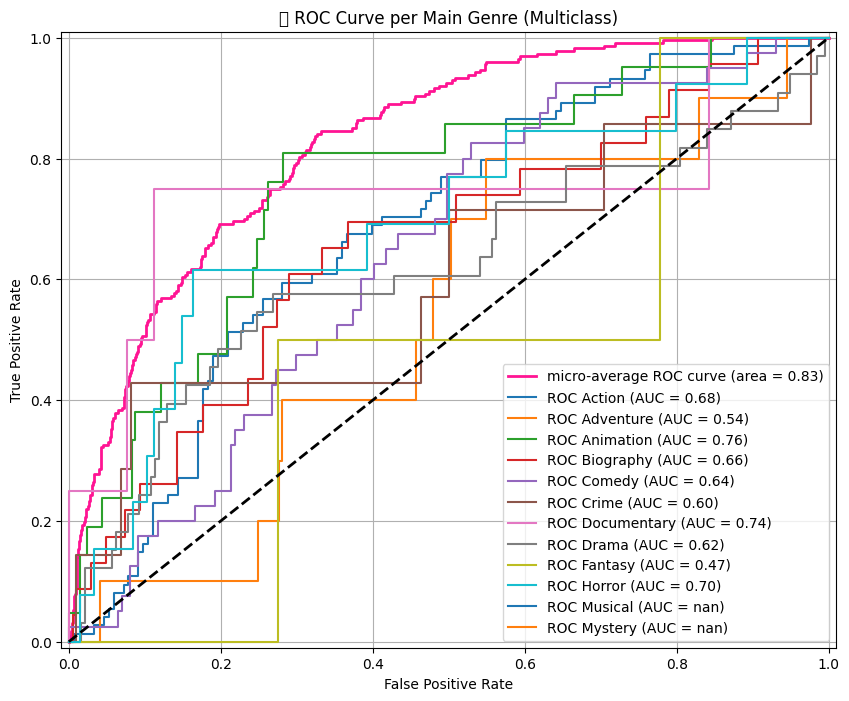

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarizo klasat (y_true dhe y_pred_probs)
y_true_bin = y_test
y_score = y_pred_probs
n_classes = y_true_bin.shape[1]

# Kurba ROC për çdo klasë
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Mikro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotimi
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)

# Kurba për çdo klasë veçmas
for i in range(n_classes):
    class_name = le.inverse_transform([i])[0]
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f'ROC {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve per Main Genre (Multiclass)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [13]:
### rating category

In [14]:
# 🎯 Target i ri: rating_category
le_rating = LabelEncoder()
y_rating = le_rating.fit_transform(df["rating_category"])
y_rating_cat = to_categorical(y_rating)

# Përdor të njëjtin X si më parë
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_rating_cat, test_size=0.2, random_state=42)


In [15]:
# 🧠 Modeli për rating
model_rating = Sequential()
model_rating.add(Masking(mask_value=0.0, input_shape=(100, 1)))
model_rating.add(LSTM(64))
model_rating.add(Dropout(0.3))
model_rating.add(Dense(y_rating_cat.shape[1], activation='softmax'))

model_rating.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trajnimi
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history_rating = model_rating.fit(X_train_r, y_train_r, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.3103 - loss: 1.5692 - val_accuracy: 0.3571 - val_loss: 1.3760
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3294 - loss: 1.4027 - val_accuracy: 0.4341 - val_loss: 1.3091
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3487 - loss: 1.3486 - val_accuracy: 0.4670 - val_loss: 1.2517
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3977 - loss: 1.3269 - val_accuracy: 0.4176 - val_loss: 1.2565
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4359 - loss: 1.3124 - val_accuracy: 0.4451 - val_loss: 1.2830
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3961 - loss: 1.3319 - val_accuracy: 0.4615 - val_loss: 1.2581
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4196 - loss: 1.2919 - val_accuracy: 0.4725 - val_loss: 1.2414
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4262 - loss: 1.3379 - val_accuracy: 0.4670 -

In [16]:
from sklearn.metrics import classification_report

y_pred_probs_r = model_rating.predict(X_test_r)
y_pred_r = np.argmax(y_pred_probs_r, axis=1)
y_true_r = np.argmax(y_test_r, axis=1)

valid_labels_r = np.unique(y_true_r)
valid_names_r = le_rating.inverse_transform(valid_labels_r)

report_r = classification_report(y_true_r, y_pred_r, labels=valid_labels_r, target_names=valid_names_r)
print(report_r)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
              precision    recall  f1-score   support

        High       0.53      0.76      0.62        72
         Low       0.00      0.00      0.00         2
      Medium       0.46      0.70      0.56        82
 Medium High       0.00      0.00      0.00        45
  Medium Low       0.00      0.00      0.00        26

    accuracy                           0.49       227
   macro avg       0.20      0.29      0.24       227
weighted avg       0.34      0.49      0.40       227



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


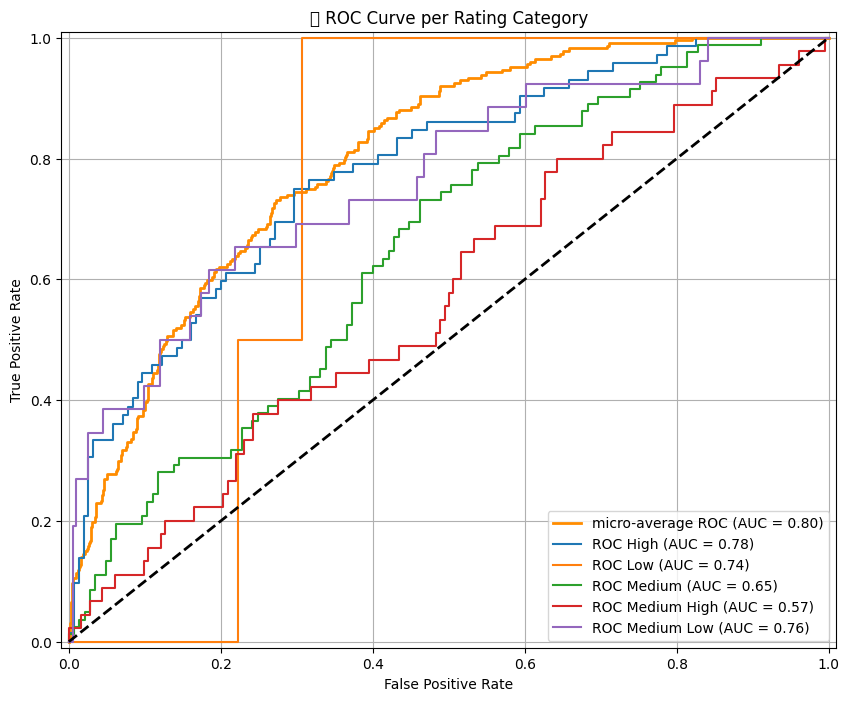

In [17]:
from sklearn.metrics import roc_curve, auc

# Binarizo klasat
y_true_bin_r = y_test_r
y_score_r = y_pred_probs_r
n_classes_r = y_true_bin_r.shape[1]

fpr_r, tpr_r, roc_auc_r = {}, {}, {}

for i in range(n_classes_r):
    fpr_r[i], tpr_r[i], _ = roc_curve(y_true_bin_r[:, i], y_score_r[:, i])
    roc_auc_r[i] = auc(fpr_r[i], tpr_r[i])

# Micro-average
fpr_r["micro"], tpr_r["micro"], _ = roc_curve(y_true_bin_r.ravel(), y_score_r.ravel())
roc_auc_r["micro"] = auc(fpr_r["micro"], tpr_r["micro"])

# Vizato
plt.figure(figsize=(10, 8))
plt.plot(fpr_r["micro"], tpr_r["micro"],
         label=f'micro-average ROC (AUC = {roc_auc_r["micro"]:.2f})', color='darkorange', linewidth=2)

for i in range(n_classes_r):
    name = le_rating.inverse_transform([i])[0]
    plt.plot(fpr_r[i], tpr_r[i], lw=1.5, label=f'ROC {name} (AUC = {roc_auc_r[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve per Rating Category')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
